# Dependencies

In [ ]:
# I suggest to install them directly on terminal
!pip install tensorflow==2.3.4
!pip install tensorflow-io

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import tensorflow as tf
import tensorflow_io as tfio
from keras.callbacks import EarlyStopping
from PIL import Image

2025-11-24 16:37:48.783270: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-24 16:37:49.484944: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-11-24 16:37:52.109658: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-11-24 16:37:52.112703: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-11-24 16:37:59.416985: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

# From-Scratch

## Splitting

In [2]:
train_directory = 'train/'

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_directory, labels='inferred', label_mode='int', image_size=(256, 256), seed=123,
    validation_split=0.2, subset='validation')

class_names = train_ds.class_names
print(class_names)

Found 2477 files belonging to 2 classes.
Using 495 files for validation.
Using 495 files for validation.
['0', '1']
['0', '1']


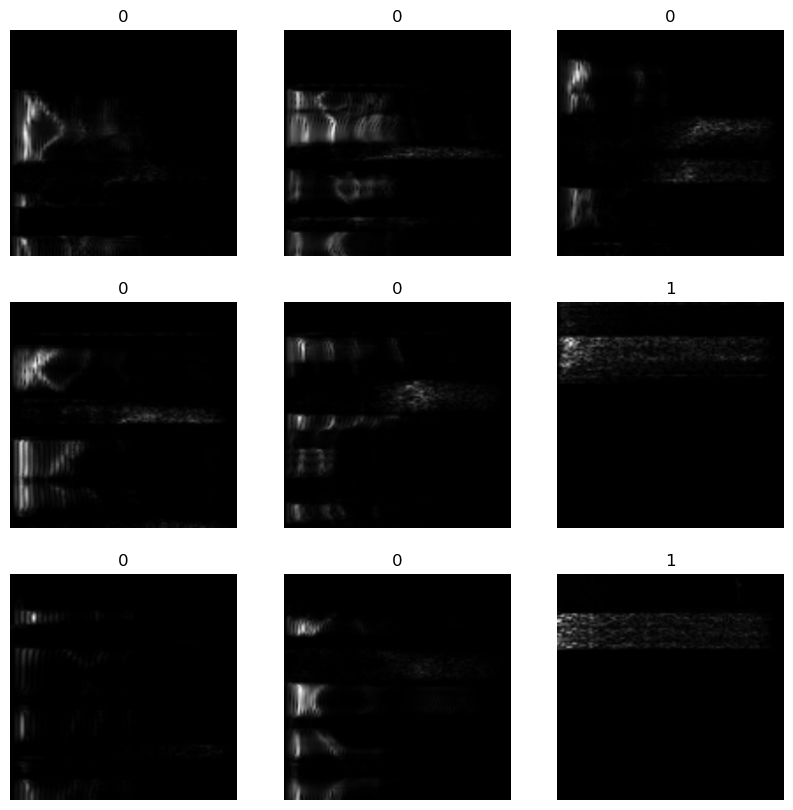

In [3]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [4]:
num_classes = 2
img_height = 256
img_width = 256

early_stopping = EarlyStopping(
    monitor="accuracy",
    restore_best_weights=True,
    start_from_epoch=0,
)

model = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes, activation='softmax'),

])

In [ ]:
learning_rate = 0.125

loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.SGD(learning_rate)
metrics = ['accuracy']
model.compile(optimizer, loss_fn, metrics)

In [6]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 256, 256, 3)       0         
                                                                 
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 16)      448       
 conv2d (Conv2D)             (None, 256, 256, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 128, 128, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      4

In [7]:
epochs = 15

history = model.fit(train_ds, epochs=epochs, callbacks=[early_stopping])

Epoch 1/15


/home/dhekmass/anaconda3/envs/msd/lib/python3.11/site-packages/keras/src/backend.py:5714: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


16/16 [==============================] - 8s 335ms/step - loss: 0.1881 - accuracy: 0.9091
Epoch 2/15
16/16 [==============================] - 8s 335ms/step - loss: 0.1881 - accuracy: 0.9091
Epoch 2/15
16/16 [==============================] - 6s 386ms/step - loss: 0.0021 - accuracy: 1.0000
Epoch 3/15
16/16 [==============================] - 6s 386ms/step - loss: 0.0021 - accuracy: 1.0000
Epoch 3/15
16/16 [==============================] - 7s 409ms/step - loss: 9.7366e-04 - accuracy: 1.0000


## Testing

In [8]:
test_directory = 'test/'

def validate_images(directory):
    for root, _, files in os.walk(directory):
        for file in files:
            file_path = os.path.join(root, file)
            try:
                with Image.open(file_path) as img:
                    img.verify()
            except (IOError, SyntaxError):
                print(f"Invalid image file removed: {file_path}")
                os.remove(file_path)

validate_images(test_directory)

In [9]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_directory, labels='inferred', label_mode='int', image_size=(256, 256), 
    validation_split=None, subset=None)

mean_confidence = 0
correct = 0
test_size = 0

for batch_num, (X, Y) in enumerate(test_ds):
    batch_size = len(Y)
    test_size += batch_size
    pred = model.predict(X)
    for i in range(batch_size):
        mean_confidence += np.max(pred[i], axis=-1)
        predicted = np.argmax(pred[i], axis=-1)
        actual = Y[i]
        #print(f'predicted {predicted}, actual {actual}')
        if predicted == actual:
            correct += 1

mean_confidence /= test_size

print(f'Number correct: {correct} out of {test_size}')
print(f'Accuracy {correct / test_size}')
print(f'Mean Confidence Score {mean_confidence}')

Found 3489 files belonging to 2 classes.
1/1 [==============================] - 0s 119ms/step
Number correct: 3479 out of 3489
Accuracy 0.99713384924047
Mean Confidence Score 0.9977833556561732
1/1 [==============================] - 0s 119ms/step
Number correct: 3479 out of 3489
Accuracy 0.99713384924047
Mean Confidence Score 0.9977833556561732


In [10]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_directory, labels='inferred', label_mode='int', image_size=(256, 256), 
    validation_split=None, subset=None)

mean_confidence = 0
correct = 0
test_size = 0

predictions = []
actuals = []

for batch_num, (X, Y) in enumerate(test_ds):
    batch_size = len(Y)
    test_size += batch_size
    pred = model.predict(X)
    for i in range(batch_size):
        mean_confidence += np.max(pred[i], axis=-1)
        predicted = np.argmax(pred[i], axis=-1)
        actual = Y[i]

        predictions.append(predicted)
        actuals.append(actual)
        #print(f'predicted {predicted}, actual {actual}')
        if predicted == actual:
            correct += 1

mean_confidence /= test_size

print(f'Number correct: {correct} out of {test_size}')
print(f'Accuracy {correct / test_size}')
print(f'Mean Confidence Score {mean_confidence}')

Found 3489 files belonging to 2 classes.
1/1 [==============================] - 0s 33ms/step
Number correct: 3479 out of 3489
Accuracy 0.99713384924047
Mean Confidence Score 0.9977833556561732


1/1 [==============================] - 0s 37ms/step


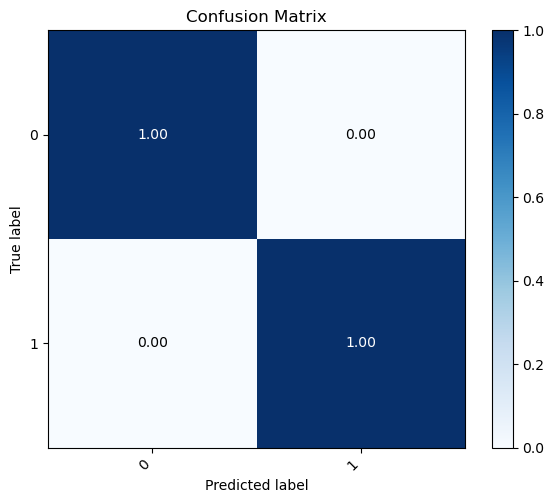

In [11]:
def plot_confusion_matrix(model, dataset, class_names=None, normalize=False, cmap='Blues'):
    y_true, y_pred = [], []

    for X, y in dataset:
        preds = model.predict(X)
        y_pred.extend(np.argmax(preds, axis=-1).tolist())
        y_true.extend(y.numpy().tolist())

    y_true = np.array(y_true, dtype=int)
    y_pred = np.array(y_pred, dtype=int)

    num_classes = int(max(y_true.max() if y_true.size else 0,
                          y_pred.max() if y_pred.size else 0) + 1)
    cm = tf.math.confusion_matrix(y_true, y_pred, num_classes=num_classes).numpy()

    if normalize:
        with np.errstate(all='ignore'):
            row_sums = cm.sum(axis=1, keepdims=True)
            cm = np.divide(cm, row_sums, where=row_sums != 0)
        cm = np.nan_to_num(cm)

    fig, ax = plt.subplots(figsize=(6, 5))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)

    if class_names is None:
        class_names = [f'class_{i}' for i in range(num_classes)]

    ax.set(
        xticks=np.arange(num_classes),
        yticks=np.arange(num_classes),
        xticklabels=class_names,
        yticklabels=class_names,
        xlabel='Predicted label',
        ylabel='True label',
        title='Confusion Matrix'
    )
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.0 if cm.size else 0.5
    for i in range(num_classes):
        for j in range(num_classes):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha='center', va='center',
                    color='white' if cm[i, j] > thresh else 'black')

    fig.tight_layout()
    plt.show()

plot_confusion_matrix(model, test_ds, class_names=class_names, normalize=True)

In [12]:
predictions = np.array(predictions)
actuals = np.array(actuals)

def compute_recall(class_names=None):

    num_classes = int(max(actuals.max(), predictions.max()) + 1)
    cm = tf.math.confusion_matrix(actuals, predictions, num_classes=num_classes).numpy()

    with np.errstate(divide='ignore', invalid='ignore'):
        recall_per_class = np.divide(np.diag(cm), cm.sum(axis=1), where=cm.sum(axis=1)!=0)
    recall_per_class = np.nan_to_num(recall_per_class)

    if class_names is None:
        class_names = [f'class_{i}' for i in range(num_classes)]

    for idx, name in enumerate(class_names):
        print(f'Recall ({name}): {recall_per_class[idx]:.4f}')

    macro_recall = recall_per_class.mean()
    print(f'Macro Recall: {macro_recall:.4f}')
    return recall_per_class, macro_recall

compute_recall(class_names=class_names)


Recall (0): 0.9970
Recall (1): 1.0000
Macro Recall: 0.9985


(array([0.99701849, 1.        ]), 0.9985092426952893)

## Inference

In [14]:
inference_directory = 'inference/'

def validate_images(directory):
    for root, _, files in os.walk(directory):
        for file in files:
            file_path = os.path.join(root, file)
            try:
                with Image.open(file_path) as img:
                    img.verify()
            except (IOError, SyntaxError):
                print(f"Invalid image file removed: {file_path}")
                os.remove(file_path)

validate_images(inference_directory)

In [15]:
inference_ds = tf.keras.preprocessing.image_dataset_from_directory(
    inference_directory, labels='inferred', label_mode='int', image_size=(256, 256), 
    validation_split=None, subset=None)

mean_confidence = 0
correct = 0
test_size = 0

for batch_num, (X, Y) in enumerate(inference_ds):
    batch_size = len(Y)
    test_size += batch_size
    pred = model.predict(X)
    for i in range(batch_size):
        mean_confidence += np.max(pred[i], axis=-1)
        predicted = np.argmax(pred[i], axis=-1)
        actual = Y[i]
        if predicted == actual:
            correct += 1

mean_confidence /= test_size

print(f'Number correct: {correct} out of {test_size}')
print(f'Accuracy {correct / test_size}')
print(f'Mean Confidence Score {mean_confidence}')

Found 6 files belonging to 2 classes.
1/1 [==============================] - 0s 44ms/step
Number correct: 6 out of 6
Accuracy 1.0
Mean Confidence Score 0.9246528744697571
1/1 [==============================] - 0s 44ms/step
Number correct: 6 out of 6
Accuracy 1.0
Mean Confidence Score 0.9246528744697571


## Save Model

In [16]:
model.save('from_scratch.keras')

# 2. Fine-Tuning (Combined with Crowd Sound)

## Splitting

In [17]:
train_directory = 'train_2/'

def validate_images(directory):
    global counter
    for root, _, files in os.walk(directory):
        for file in files:
            file_path = os.path.join(root, file)
            try:
                with Image.open(file_path) as img:
                    img.verify()
            except (IOError, SyntaxError):
                print(f"Invalid image file removed: {file_path}")
                os.remove(file_path)

validate_images(train_directory)

In [18]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_directory, labels='inferred', label_mode='int', image_size=(256, 256), seed=123,
    validation_split=0.2, subset='validation')

class_names = train_ds.class_names
print(class_names)

Found 2460 files belonging to 2 classes.
Using 492 files for validation.
['0', '1']
Using 492 files for validation.
['0', '1']


## Modelling

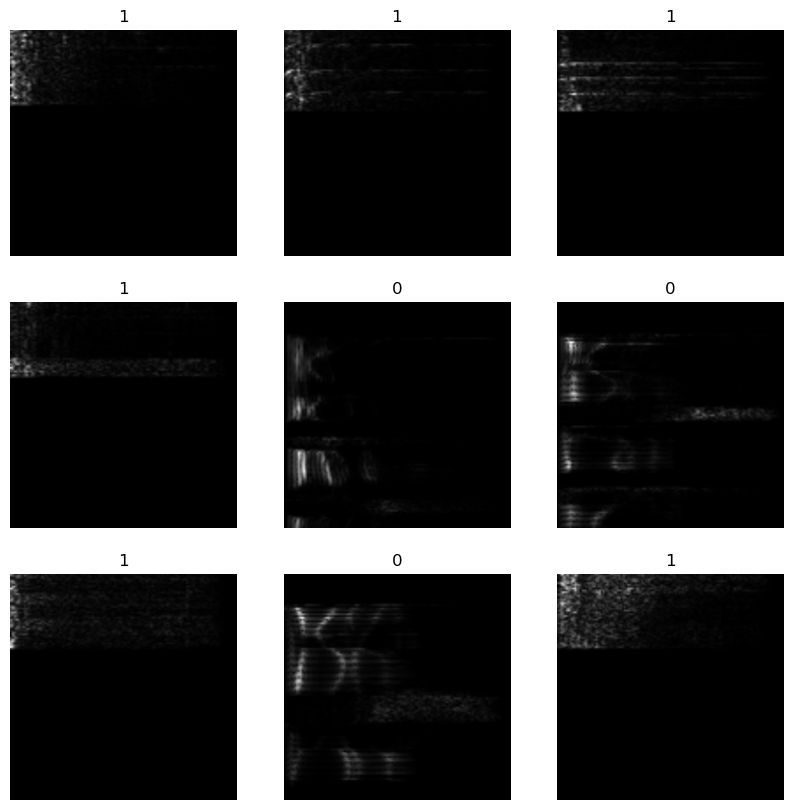

In [19]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [20]:
epochs = 15

crowd_model = tf.keras.models.load_model('from_scratch.keras')
history = crowd_model.fit(train_ds, epochs=epochs, callbacks=[early_stopping])

Epoch 1/15


/home/dhekmass/anaconda3/envs/msd/lib/python3.11/site-packages/keras/src/backend.py:5714: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


16/16 [==============================] - 11s 663ms/step - loss: 0.0013 - accuracy: 1.0000
Epoch 2/15
16/16 [==============================] - 11s 663ms/step - loss: 0.0013 - accuracy: 1.0000
Epoch 2/15
16/16 [==============================] - 5s 295ms/step - loss: 7.4646e-04 - accuracy: 1.0000


## Testing

In [21]:
test_directory = 'test/'

def validate_images(directory):
    for root, _, files in os.walk(directory):
        for file in files:
            file_path = os.path.join(root, file)
            try:
                with Image.open(file_path) as img:
                    img.verify()
            except (IOError, SyntaxError):
                print(f"Invalid image file removed: {file_path}")
                os.remove(file_path)

validate_images(test_directory)

In [22]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_directory, labels='inferred', label_mode='int', image_size=(256, 256), 
    validation_split=None, subset=None)

mean_confidence = 0
correct = 0
test_size = 0

for batch_num, (X, Y) in enumerate(test_ds):
    batch_size = len(Y)
    test_size += batch_size
    pred = model.predict(X)
    for i in range(batch_size):
        mean_confidence += np.max(pred[i], axis=-1)
        predicted = np.argmax(pred[i], axis=-1)
        actual = Y[i]
        #print(f'predicted {predicted}, actual {actual}')
        if predicted == actual:
            correct += 1

mean_confidence /= test_size

print(f'Number correct: {correct} out of {test_size}')
print(f'Accuracy {correct / test_size}')
print(f'Mean Confidence Score {mean_confidence}')

Found 3489 files belonging to 2 classes.
1/1 [==============================] - 0s 37ms/step
Number correct: 3479 out of 3489
Accuracy 0.99713384924047
Mean Confidence Score 0.9977833556561732
1/1 [==============================] - 0s 37ms/step
Number correct: 3479 out of 3489
Accuracy 0.99713384924047
Mean Confidence Score 0.9977833556561732


1/1 [==============================] - 0s 37ms/step


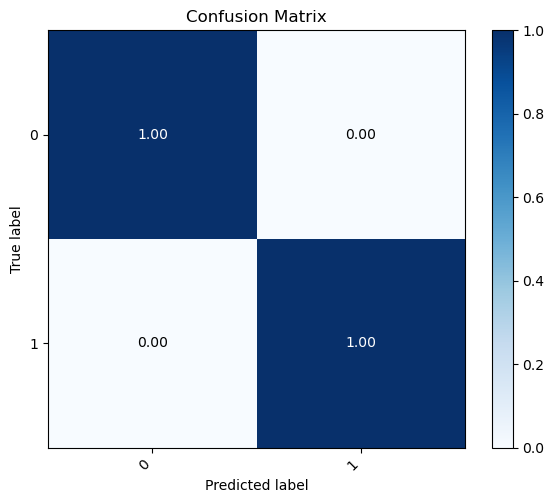

In [24]:
def plot_confusion_matrix(model, dataset, class_names=None, normalize=False, cmap='Blues'):
    y_true, y_pred = [], []

    for X, y in dataset:
        preds = model.predict(X)
        y_pred.extend(np.argmax(preds, axis=-1).tolist())
        y_true.extend(y.numpy().tolist())

    y_true = np.array(y_true, dtype=int)
    y_pred = np.array(y_pred, dtype=int)

    num_classes = int(max(y_true.max() if y_true.size else 0,
                          y_pred.max() if y_pred.size else 0) + 1)
    cm = tf.math.confusion_matrix(y_true, y_pred, num_classes=num_classes).numpy()

    if normalize:
        with np.errstate(all='ignore'):
            row_sums = cm.sum(axis=1, keepdims=True)
            cm = np.divide(cm, row_sums, where=row_sums != 0)
        cm = np.nan_to_num(cm)

    fig, ax = plt.subplots(figsize=(6, 5))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)

    if class_names is None:
        class_names = [f'class_{i}' for i in range(num_classes)]

    ax.set(
        xticks=np.arange(num_classes),
        yticks=np.arange(num_classes),
        xticklabels=class_names,
        yticklabels=class_names,
        xlabel='Predicted label',
        ylabel='True label',
        title='Confusion Matrix'
    )
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.0 if cm.size else 0.5
    for i in range(num_classes):
        for j in range(num_classes):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha='center', va='center',
                    color='white' if cm[i, j] > thresh else 'black')

    fig.tight_layout()
    plt.show()

plot_confusion_matrix(model, test_ds, class_names=class_names, normalize=True)

In [25]:
predictions = np.array(predictions)
actuals = np.array(actuals)

def compute_recall(class_names=None):

    num_classes = int(max(actuals.max(), predictions.max()) + 1)
    cm = tf.math.confusion_matrix(actuals, predictions, num_classes=num_classes).numpy()

    with np.errstate(divide='ignore', invalid='ignore'):
        recall_per_class = np.divide(np.diag(cm), cm.sum(axis=1), where=cm.sum(axis=1)!=0)
    recall_per_class = np.nan_to_num(recall_per_class)

    if class_names is None:
        class_names = [f'class_{i}' for i in range(num_classes)]

    for idx, name in enumerate(class_names):
        print(f'Recall ({name}): {recall_per_class[idx]:.4f}')

    macro_recall = recall_per_class.mean()
    print(f'Macro Recall: {macro_recall:.4f}')
    return recall_per_class, macro_recall

compute_recall(class_names=class_names)


Recall (0): 0.9972
Recall (1): 1.0000
Macro Recall: 0.9986


(array([0.99717913, 1.        ]), 0.998589562764457)

## Inference

In [26]:
inference_directory = 'inference/'

def validate_images(directory):
    for root, _, files in os.walk(directory):
        for file in files:
            file_path = os.path.join(root, file)
            try:
                with Image.open(file_path) as img:
                    img.verify()
            except (IOError, SyntaxError):
                print(f"Invalid image file removed: {file_path}")
                os.remove(file_path)

validate_images(inference_directory)

In [27]:
inference_ds = tf.keras.preprocessing.image_dataset_from_directory(
    inference_directory, labels='inferred', label_mode='int', image_size=(256, 256), 
    validation_split=None, subset=None)

mean_confidence = 0
correct = 0
test_size = 0

for batch_num, (X, Y) in enumerate(inference_ds):
    batch_size = len(Y)
    test_size += batch_size
    pred = crowd_model.predict(X)
    for i in range(batch_size):
        mean_confidence += np.max(pred[i], axis=-1)
        predicted = np.argmax(pred[i], axis=-1)
        actual = Y[i]
        if predicted == actual:
            correct += 1

mean_confidence /= test_size

print(f'Number correct: {correct} out of {test_size}')
print(f'Accuracy {correct / test_size}')
print(f'Mean Confidence Score {mean_confidence}')

Found 6 files belonging to 2 classes.
1/1 [==============================] - 0s 182ms/step
Number correct: 6 out of 6
Accuracy 1.0
Mean Confidence Score 0.9314993421236674


## Save Model

In [28]:
crowd_model.save('crowd_model.keras')

# 3. Fine-Tuning (Energy Modification)

## Splitting

In [29]:
train_directory = 'train_3/'

def validate_images(directory):
    global counter
    for root, _, files in os.walk(directory):
        for file in files:
            file_path = os.path.join(root, file)
            try:
                with Image.open(file_path) as img:
                    img.verify()
            except (IOError, SyntaxError):
                print(f"Invalid image file removed: {file_path}")
                os.remove(file_path)

validate_images(train_directory)

In [30]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_directory, labels='inferred', label_mode='int', image_size=(256, 256), seed=123,
    validation_split=0.2, subset='validation')

class_names = train_ds.class_names
print(class_names)

Found 2475 files belonging to 2 classes.
Using 495 files for validation.
['0', '1']
Using 495 files for validation.
['0', '1']


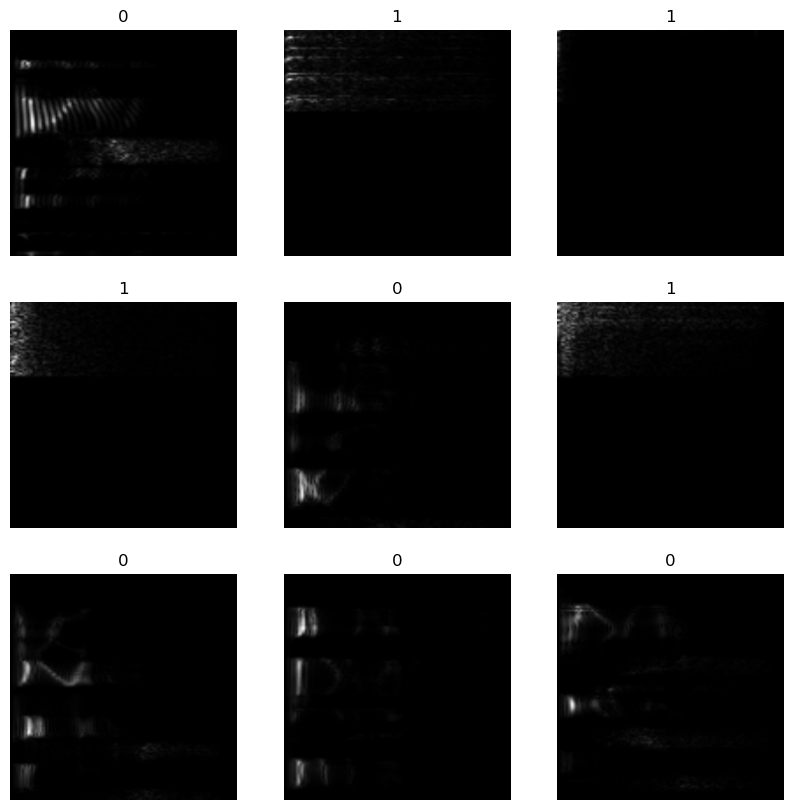

In [31]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [32]:
epochs = 15

energy_model = tf.keras.models.load_model('from_scratch.keras')
history = energy_model.fit(train_ds, epochs=epochs, callbacks=[early_stopping])

Epoch 1/15


/home/dhekmass/anaconda3/envs/msd/lib/python3.11/site-packages/keras/src/backend.py:5714: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


16/16 [==============================] - 5s 277ms/step - loss: 0.0014 - accuracy: 1.0000
Epoch 2/15
16/16 [==============================] - 4s 276ms/step - loss: 7.2305e-04 - accuracy: 1.0000


## Testing

In [33]:
test_directory = 'test/'

def validate_images(directory):
    for root, _, files in os.walk(directory):
        for file in files:
            file_path = os.path.join(root, file)
            try:
                with Image.open(file_path) as img:
                    img.verify()
            except (IOError, SyntaxError):
                print(f"Invalid image file removed: {file_path}")
                os.remove(file_path)

validate_images(test_directory)

In [34]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_directory, labels='inferred', label_mode='int', image_size=(256, 256), 
    validation_split=None, subset=None)

mean_confidence = 0
correct = 0
test_size = 0

for batch_num, (X, Y) in enumerate(test_ds):
    batch_size = len(Y)
    test_size += batch_size
    pred = model.predict(X)
    for i in range(batch_size):
        mean_confidence += np.max(pred[i], axis=-1)
        predicted = np.argmax(pred[i], axis=-1)
        actual = Y[i]
        #print(f'predicted {predicted}, actual {actual}')
        if predicted == actual:
            correct += 1

mean_confidence /= test_size

print(f'Number correct: {correct} out of {test_size}')
print(f'Accuracy {correct / test_size}')
print(f'Mean Confidence Score {mean_confidence}')

Found 3489 files belonging to 2 classes.
1/1 [==============================] - 0s 34ms/step
Number correct: 3479 out of 3489
Accuracy 0.99713384924047
Mean Confidence Score 0.9977833556561732


1/1 [==============================] - 0s 30ms/step


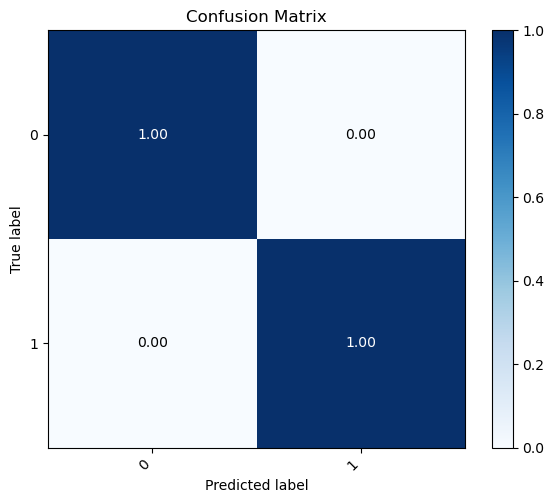

In [38]:
def plot_confusion_matrix(model, dataset, class_names=None, normalize=False, cmap='Blues'):
    y_true, y_pred = [], []

    for X, y in dataset:
        preds = model.predict(X)
        y_pred.extend(np.argmax(preds, axis=-1).tolist())
        y_true.extend(y.numpy().tolist())

    y_true = np.array(y_true, dtype=int)
    y_pred = np.array(y_pred, dtype=int)

    num_classes = int(max(y_true.max() if y_true.size else 0,
                          y_pred.max() if y_pred.size else 0) + 1)
    cm = tf.math.confusion_matrix(y_true, y_pred, num_classes=num_classes).numpy()

    if normalize:
        with np.errstate(all='ignore'):
            row_sums = cm.sum(axis=1, keepdims=True)
            cm = np.divide(cm, row_sums, where=row_sums != 0)
        cm = np.nan_to_num(cm)

    fig, ax = plt.subplots(figsize=(6, 5))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)

    if class_names is None:
        class_names = [f'class_{i}' for i in range(num_classes)]

    ax.set(
        xticks=np.arange(num_classes),
        yticks=np.arange(num_classes),
        xticklabels=class_names,
        yticklabels=class_names,
        xlabel='Predicted label',
        ylabel='True label',
        title='Confusion Matrix'
    )
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.0 if cm.size else 0.5
    for i in range(num_classes):
        for j in range(num_classes):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha='center', va='center',
                    color='white' if cm[i, j] > thresh else 'black')

    fig.tight_layout()
    plt.show()

plot_confusion_matrix(model, test_ds, class_names=class_names, normalize=True)

In [39]:
predictions = np.array(predictions)
actuals = np.array(actuals)

def compute_recall(class_names=None):

    num_classes = int(max(actuals.max(), predictions.max()) + 1)
    cm = tf.math.confusion_matrix(actuals, predictions, num_classes=num_classes).numpy()

    with np.errstate(divide='ignore', invalid='ignore'):
        recall_per_class = np.divide(np.diag(cm), cm.sum(axis=1), where=cm.sum(axis=1)!=0)
    recall_per_class = np.nan_to_num(recall_per_class)

    if class_names is None:
        class_names = [f'class_{i}' for i in range(num_classes)]

    for idx, name in enumerate(class_names):
        print(f'Recall ({name}): {recall_per_class[idx]:.4f}')

    macro_recall = recall_per_class.mean()
    print(f'Macro Recall: {macro_recall:.4f}')
    return recall_per_class, macro_recall

compute_recall(class_names=class_names)


Recall (0): 0.9972
Recall (1): 1.0000
Macro Recall: 0.9986


(array([0.99717913, 1.        ]), 0.998589562764457)

## Inference

In [35]:
inference_directory = 'inference/'

def validate_images(directory):
    for root, _, files in os.walk(directory):
        for file in files:
            file_path = os.path.join(root, file)
            try:
                with Image.open(file_path) as img:
                    img.verify()
            except (IOError, SyntaxError):
                print(f"Invalid image file removed: {file_path}")
                os.remove(file_path)

validate_images(inference_directory)

In [36]:
inference_ds = tf.keras.preprocessing.image_dataset_from_directory(
    inference_directory, labels='inferred', label_mode='int', image_size=(256, 256), 
    validation_split=None, subset=None)

mean_confidence = 0
correct = 0
test_size = 0

for batch_num, (X, Y) in enumerate(inference_ds):
    batch_size = len(Y)
    test_size += batch_size
    pred = energy_model.predict(X)
    for i in range(batch_size):
        mean_confidence += np.max(pred[i], axis=-1)
        predicted = np.argmax(pred[i], axis=-1)
        actual = Y[i]
        if predicted == actual:
            correct += 1

mean_confidence /= test_size

print(f'Number correct: {correct} out of {test_size}')
print(f'Accuracy {correct / test_size}')
print(f'Mean Confidence Score {mean_confidence}')

Found 6 files belonging to 2 classes.
1/1 [==============================] - 0s 128ms/step
Number correct: 6 out of 6
Accuracy 1.0
Mean Confidence Score 0.8799026111761729


## Save Model

In [37]:
energy_model.save('energy_model.keras')